In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/project') # main working directory

In [3]:
base_path='MMU-Iris-Database'

In [4]:
dir_='segmented/'

In [5]:
import matplotlib.pyplot as plt
import random
import os
import cv2
import numpy as np
import tqdm
import itertools
# from daugman_visual_explanation import DaugmanVisualExplanation
from daugman import find_iris
from typing import List, Tuple, Iterable

In [7]:
class Daugman_class:
    def __init__(self, img_path: str, start_r=5, end_r=15, circle_step=2, points_step=3):
        self.img = self._get_new_image(img_path)
        self.start_r = start_r
        self.end_r = end_r
        self.circle_step = circle_step
        self.points_step = points_step
        self.all_points = self._get_all_potential_iris_centers(self.img)
        self.colors = self._get_unique_color_for_each_point(self.all_points)
    def _get_all_potential_iris_centers(self, img: np.ndarray) -> List[Tuple[int, int]]:
        # get all potential points for search (from `find_iris()`)
        h = img.shape[0]
        # we will look only on dots within central 1/3 of image
        single_axis_range = range(int(h / 3), h - int(h / 3), self.points_step)
        all_points = list(itertools.product(single_axis_range, single_axis_range))
        return all_points

    def _get_unique_color_for_each_point(self, all_points: List[Tuple[int, int]]) -> List[Tuple[int, int, int]]:
        colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in self.all_points]
        return colors
    def _get_new_image(self, img_path, gray=False) -> np.ndarray:
        # Get properly cropped BGR image, which looks like grayscale
        img = cv2.imread(img_path)
        img = img[20:220, 60:260]
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if gray:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img
    def find_iris(self, *, daugman_start, daugman_end, daugman_step, points_step) -> np.ndarray:
        # plt.imshow(self.img[::, ::, ::-1])
        gray_img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        answer = find_iris(gray_img, daugman_start=daugman_start, daugman_end=daugman_end,
                           daugman_step=daugman_step, points_step=points_step)
        iris_center, iris_rad = answer
        out = self.img.copy()
        cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
        _ = plt.imshow(out[::, ::, ::-1])


        height,width,_ = self.img.shape
        # print(height,width)
        mask = np.zeros((height,width), np.uint8)

        circle_img = cv2.circle(mask,iris_center,iris_rad,(255,255,255),-1)
        masked_data = cv2.bitwise_and(self.img, self.img, mask=circle_img)
        _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
        contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        # print(contours[0][0])
        x,y,w,h = cv2.boundingRect(contours[0][0])
        crop = masked_data[y:y+h,x:x+w]
        # crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        # cv2.imwrite('sssss.jpg',out)
        # _ = plt.imshow(crop)
        return crop

100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


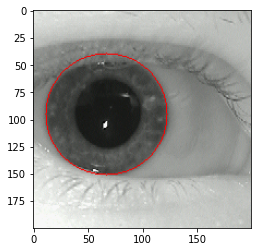

In [8]:
for folder in os.listdir(base_path):
  folder_path=os.path.join(base_path,folder)
  new_path=os.path.join('segmented',folder)
  if not os.path.exists(new_path):
    os.makedirs(new_path)
  for img_name in tqdm.tqdm(os.listdir(folder_path)):
    img_path=os.path.join(folder_path,img_name)
    duagman_ = Daugman_class(img_path)
    output = duagman_.find_iris(daugman_start=30, daugman_end=60, daugman_step=1, points_step=1)
    cv2.imwrite(os.path.join(new_path,img_name),output)

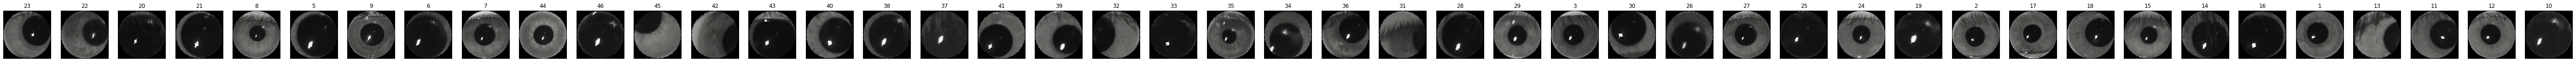

In [9]:
from keras.preprocessing.image import  load_img
plt.figure(figsize=(100,50))
i = 1
folder_list=os.listdir(dir_)
for folder in folder_list:
    img = load_img((dir_ + folder +'/'+ os.listdir(dir_ + folder)[1]))
    plt.subplot(1,len(folder_list),i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
plt.show()